In [99]:
import numpy as np
import scipy.constants as sc
from scipy.fft import fft,ifft,fftfreq
import matplotlib.pyplot as plt
from numpy import linalg as LA
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm_notebook
import mpl_toolkits.mplot3d as mplot3d
import scipy.special as ss
from scipy.integrate import quad, dblquad
N =801
k = int(N/4)
alpha=np.pad(ss.jnp_zeros(0,N),(1,0),'constant',constant_values=(0)) # zeros of first derivative of zeroth order bessel function 
##starts from n=1 rather than n = 0
J0 = ss.jn_zeros(0,N+2) #zeros of zeroth order bessel function
b = 50
beta = S/(2*np.pi*b)
S = ss.jv(0,alpha[k]*alpha/J0[N+1])**2
S /= ss.jv(0,alpha)**2
S = np.sqrt(1+sum(S)-S[0])
S /= np.abs(ss.jv(0,alpha[k]))/2
C = np.zeros((N+1,N+1))
for i in tqdm_notebook(range(N+1),leave = False):
    for j in range(N+1):
        C[i,j] = ss.jv(0,alpha[i]*alpha[j]/S)
        C[i,j] /= S*np.abs(ss.jv(0,alpha[i]))*np.abs(ss.jv(0,alpha[j]))/2
def F(f,J):
    out = f*b/J
    return out
def G(g,J):
    out = g*beta/J
    return out
def Finv(f,J):
    out = f*J/b
    return out
def Ginv(g,J):
    out = g*J/beta
    return out


def qfht(psi,J):
    out = F(psi,J) #changes variables
    out = np.matmul(C,out)#applies transformation matrix 
    out = Ginv(out,J)
    return out
def iqfht(psi,J):
    out = G(psi,J)
    out = np.matmul(C,out)
    out = Finv(out,J)
    return out
  

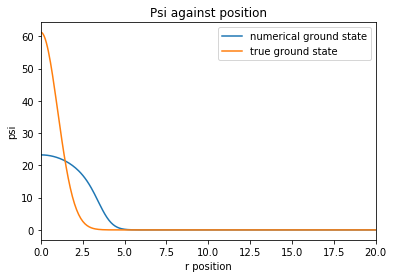

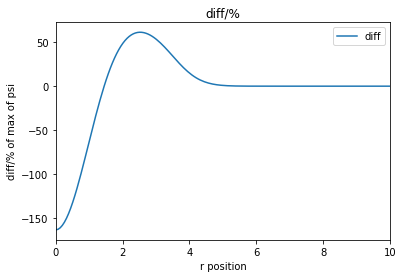

In [101]:
from numpy.fft import fft2,ifft2
No = 3e4 #number of particles
m = 2.7774e-25
w=100*np.pi
dt = -0.01j
r = alpha*b/S
rho = alpha*beta/S
J = np.abs(ss.jv(0,alpha))

##for harmonic
xs = np.sqrt(sc.hbar/(m*w))

a = 5.1e-9 
gs = 4*np.pi*a*No/xs #(not g, g in dimensionless units)
g = 4*np.pi*(sc.hbar**2)*a/m

Rc = b+1
mu =6.98
mu_B =9.2740100783e-24
Cdd = sc.mu_0*(mu*mu_B)**2
lamda = (m*No*Cdd)/(3*(sc.hbar**2)*xs) 
# dimensionless variables

def dd_cont(psi):
    out = lamda/3
    out+= lamda*np.cos(Rc*2*np.pi*rho)/(Rc*2*np.pi*rho)**2
    out = np.nan_to_num(out)
    out = out-lamda*np.sin(Rc*2*np.pi*rho)/(Rc*2*np.pi*rho)**3
    out = np.nan_to_num(out)
    out*= -1 #kz/k_mag=cos(theta_k) where theta_k is the 
    #angle between k and the direction of the dipoles, I'm assuming z is 
    #the direction of the dipoles, gives cos(theta_k)=0
    out = iqfht(out*np.abs(qfht(np.abs(psi)**2,J)),J) ## needs to be normalised
    return out
#dd_cont is based on the 3D version, don't think it applies to 2D

#harmonic potential
def V(psi):
    out = 0.5*r**2  +(gs*np.abs(psi)**2)/(2*np.pi)#+ np.abs(dd_cont(psi))##taking absolute value as this term should be positive
    return out
##think reason for discrepancy between this and 2D cartesian which doesn't appear with no interactions is gs is very large
##so the error and variation with this error is large with a large dt

psi = 1/np.sqrt(N)#np.exp(-r**2)
T = 0.5*(2*np.pi*rho)**2
exp_T = np.exp(-1j*dt*T)

for i in tqdm_notebook(range(2000),leave = False):
    psi = np.exp(-0.5j*dt*V(psi))*psi
    psi = exp_T * (qfht(psi,J)/LA.norm(qfht(psi,J)))
    psi = iqfht(psi,J)
    psi /= LA.norm(psi)
    psi = np.exp(-0.5j*dt*V(psi)) * psi
    psi /= LA.norm(psi)

    
###normalisation condition for polar coords is different
psi /= np.sqrt(np.sum(r*(np.abs(psi)**2)))       
#psi /= np.sqrt(2*np.pi) #for a specific angle
psi *= np.sqrt(No) 


#harmonic potential    
gnd_state = np.exp((-r**2)/2)
gnd_state /= np.sqrt(np.sum(r*(np.abs(gnd_state)**2)))    
gnd_state *= np.sqrt(No)

plt.plot(r,np.abs(psi), label ="numerical ground state")
plt.plot(r,gnd_state, label = "true ground state")
plt.xlabel('r position')
plt.ylabel('psi')
plt.xlim(0,20)
plt.legend()
plt.title('Psi against position')
plt.show() # plots psi against x
    
diff = psi-gnd_state
#plt.plot(r,100*diff/np.abs(psi), label ="difference to solution and true ground state")
#gives 100% at r[25] as gnd_state is 0 where as psi is finite (e-44)
plt.plot(r,100*diff/np.max(psi),label="diff")
plt.xlabel('r position')
plt.ylabel('diff/% of max of psi')
#plt.ylim(-1,1)
plt.xlim(0,10)
plt.legend()
plt.title('diff/%')
plt.show() # plots psi against x

psi_r = psi


In [53]:
import plotly.graph_objects as go
import pandas as pd
from numpy.fft import fft2,ifft2
Nz = N+1
dz = 2*b/(gamma*Nz)# giving range of (-b/2,b/2) for z, gives same range of k space
nx = 100
dx = 0.1
ny = 100
x_max = dx*nx+np.max(r)
r = (alpha*b/S).reshape(-1,1).repeat(Nz,1)
z = np.linspace(-Nz*dz/2,Nz*dz/2,Nz).reshape(1,-1).repeat(N+1,0)
Zc = np.max(z)+1
dy = Zc/ny
rho= (alpha*beta/S).reshape(-1,1).repeat(Nz,1)
kz = fftfreq(len(z),dz/(2*np.pi)).reshape(1,-1).repeat(N+1,0)
x = np.linspace(np.max(r),x_max,nx).reshape(1,-1).repeat(ny,0)
y = np.linspace(0,Zc,ny).reshape(-1,1).repeat(nx,1)


def f(rho,kz):
     return x*np.cos(kz*y)*ss.jv(0,2*np.pi*rho*x)*(x**2 - 2*y**2)/(x**2 + y**2)**(5/2)

U = np.zeros((N+1,N+1))
for i in tqdm_notebook(range(N+1),leave = False):
    for j in range(N+1):
        U[i,j] = dx*dy*np.sum(f(rho[i,0],kz[0,j]))


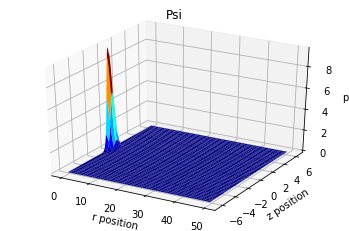

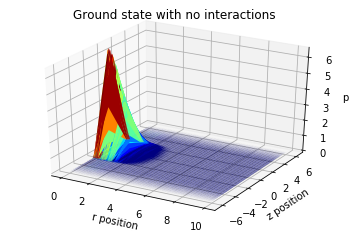

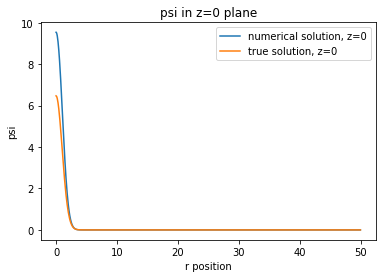

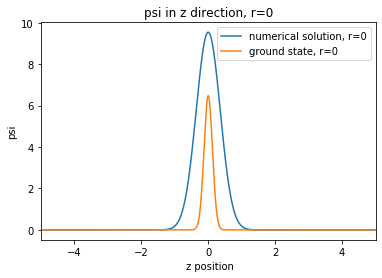

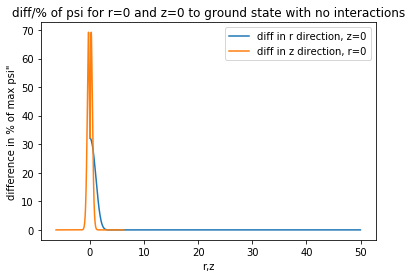

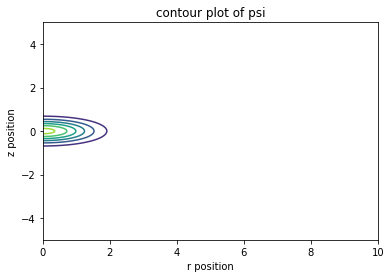

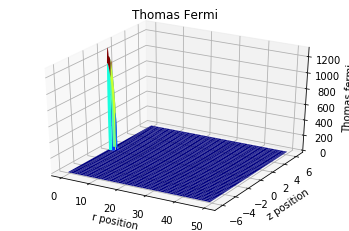

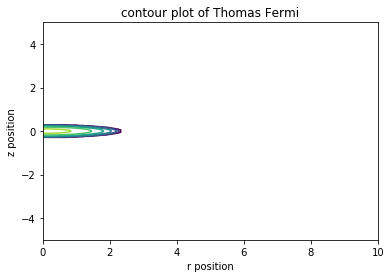

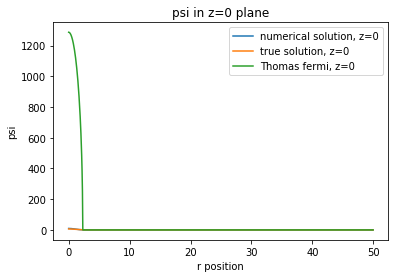

In [104]:
import plotly.graph_objects as go
import pandas as pd
from numpy.fft import fft2,ifft2
gamma = 8#1
wz = gamma*w
dt = -0.1j/gamma #change it to fit time scale of trap

Nz = N+1

dz = 2*b/(gamma*Nz)# giving range of (-b*gamma,b*gamma) for z, gives different range of k space
r = (alpha*b/S).reshape(-1,1).repeat(Nz,1)
z = np.linspace(-Nz*dz/2,Nz*dz/2,Nz).reshape(1,-1).repeat(N+1,0)
rho= (alpha*beta/S).reshape(-1,1).repeat(Nz,1)
kz = fftfreq(len(z),dz/(2*np.pi)).reshape(1,-1).repeat(N+1,0)

####make sure these above are the same as in the U code 

a = 5.1e-9 
gs = 4*np.pi*a*No/xs #(not g, g in dimensionless units)
g = 4*np.pi*(sc.hbar**2)*a/m

Rc = b+1
mu =6.98
mu_B =9.2740100783e-24
Cdd = sc.mu_0*(mu*mu_B)**2
lamda = (m*No*Cdd)/(3*(sc.hbar**2)*xs) 
# dimensionless variables

k_mag = np.sqrt(kz**2+(2*np.pi*rho)**2)
Tz  = 0.5*kz**2
exp_Tz = np.exp((-1j*dt*Tz))
exp_Tr =exp_T.reshape(-1,1)

# ##spherical cut off
# def dd_cont_cyl(psi_zr):
#     out = lamda/3
#     out+= lamda*np.cos(Rc*k_mag)/(Rc*k_mag)**2
#     out = np.nan_to_num(out)
#     out = out-lamda*np.sin(Rc*k_mag)/(Rc*k_mag)**3
#     out = np.nan_to_num(out)
#     out*= 3*(np.nan_to_num((kz/k_mag)**2))-1 
#     out = ifft2(out*fft2(psi_zr**2)) ## need to normalise fft2(psi_zr**2)
#     return out

##cylindrical cut off


theta_k =np.arccos(kz/k_mag) ##polarized in z direction
def dd_cont_cyl(psi_zr):
    out = np.nan_to_num(lamda*(3*np.cos(theta_k)**2 - 1)/3)
    out += lamda*np.exp(-Zc*2*np.pi*rho)*((np.sin(theta_k)**2)*np.cos(Zc*kz)
                            -np.sin(theta_k)*np.cos(theta_k)*np.sin(Zc*kz))
    out = np.nan_to_num(out)
    
    out -= lamda*U
    #out *= qfht(fft(psi,axis=1),J)**2
    #out /= np.sum(rho*(np.abs(out)**2))
    #out = ifft(iqfht(out,J),axis=1)
    out = ifft2(out*(fft2(psi_zr**2)/np.sum(2*np.pi*rho*(np.abs(fft2(psi_zr**2)))))) ## probably wrong
    ##normalisation is wrong
    return out 

#harmonic potential     
def Vzr(psi_zr):
    return 0.5*(r**2 + (gamma*z)**2)` +(gs*np.abs(psi_zr)**2)/(2*np.pi) #+dd_cont_cyl(psi_zr)
##the dipole term might be missing a minus sign 

psi_zr = (psi_r).reshape(-1,1).repeat(Nz,1) # initial solution is solution for 2d extended

J = np.abs(ss.jv(0,alpha)).reshape(-1,1)
for i in tqdm_notebook(range(1000),leave = False):
    psi_zr = ifft(exp_Tz*fft(np.exp(-0.5j*dt*Vzr(psi_zr))*psi_zr,axis = 1),axis = 1) #applying V and Tz
    psi_zr = iqfht(exp_Tr*qfht(psi_zr,J),J)
    psi_zr *= np.exp(-0.5j*dt*Vzr(psi_zr))
    psi_zr /= LA.norm(psi_zr)

psi_zr /= np.sqrt(np.sum(r*(np.abs(psi_zr)**2)))        
psi_zr *= np.sqrt(No)
    
##full harmonic
gnd_state = np.exp((-r**2)/2)*np.exp((-(gamma*z)**2)/2)
gnd_state /= np.sqrt(2*np.pi*np.sum(r*(np.abs(gnd_state)**2)))    
gnd_state *= np.sqrt(No)
diff_zr = np.abs(psi_zr)-np.abs(gnd_state)

fig=plt.figure()
ax = plt.axes(projection='3d')

z_cutoff = np.max(z)
bools = ((np.abs(r) <= 10)*(np.abs(z) <= z_cutoff)).ravel()
bools1 = ((np.abs(r) <= 10)*(np.abs(z) <= z_cutoff)).any(axis = 0)
bools2 = ((np.abs(r) <= 10)*(np.abs(z) <= z_cutoff)).any(axis = 1)
n1,n2 = bools1.sum(),bools2.sum()

# ax.plot_surface(r.ravel()[bools].reshape((n1,n2)),
#                 z.ravel()[bools].reshape((n1,n2)),
#                 np.abs(psi_zr).ravel()[bools].reshape((n1,n2)),
#                 cmap='jet')
ax.plot_surface(r,z,np.abs(psi_zr),cmap='jet')

ax.set_title('Psi')
ax.set_xlabel('r position')
ax.set_ylabel('z position')
ax.set_zlabel('psi')
plt.show()

ax = plt.axes(projection='3d')
ax.plot_surface(r.ravel()[bools].reshape((n1,n2)),
                z.ravel()[bools].reshape((n1,n2)),
                np.abs(gnd_state).ravel()[bools].reshape((n1,n2)),
                cmap='jet')

ax.set_title('Ground state with no interactions')
ax.set_xlabel('r position')
ax.set_ylabel('z position')
ax.set_zlabel('psi')
plt.show()

midway_index_z = int(Nz/2)
plt.plot(r[:,0],np.abs(psi_zr[:,midway_index_z]),label="numerical solution, z=0")
plt.plot(r[:,0],gnd_state[:,midway_index_z],label="true solution, z=0")
plt.title('psi in z=0 plane')
#plt.xlim(0,6)
plt.legend()
plt.xlabel('r position')
plt.ylabel('psi')
plt.show()        

plt.plot(z[0,:],np.abs(psi_zr[0,:]),label="numerical solution, r=0")
plt.plot(z[0,:],np.abs(gnd_state[0,:]),label = "ground state, r=0")
plt.title('psi in z direction, r=0')
plt.xlim(-5,5)
plt.legend()
plt.xlabel(' z position')
plt.ylabel('psi')
plt.show()  

plt.plot(r[:,0],100*diff_zr[:,midway_index_z]/np.max(psi_zr),label="diff in r direction, z=0")
plt.plot(z[0,:],100*diff_zr[0,:]/np.max(psi_zr),label="diff in z direction, r=0")
plt.title('diff/% of psi for r=0 and z=0 to ground state with no interactions')
#plt.xlim(0,6)
plt.xlabel('r,z')
plt.ylabel('difference in % of max psi"')
plt.legend()
plt.show()  

fig,ax = plt.subplots()
ax.contour(r,z,np.abs(psi_zr))
ax.set_title('contour plot of psi')
#ax.set_ylim(-1,1)
#ax.set_xlim(0,box)
ax.set_xlabel('r position')
ax.set_ylabel('z position')
ax.set_xlim([0,10])
ax.set_ylim([-5,5])
plt.show()

a__ = xs*(2**1.5)
#Thomas fermi 
w_av=(w*w*wz)**(1/3)
chem = 0.5*sc.hbar*w_av*(15*No*a/xs)**(2/5)
Rr = np.sqrt(2*chem/(m*w*w))/a__ # thomas-fermi radius for r direction
Rz = np.sqrt(2*chem/(m*wz*wz))/a__ # may need to be xs*2**1.5 for these
TF = np.sqrt(1-(r/Rr)**2 - (z/Rz)**2)
TF = np.nan_to_num(TF)
TF /= LA.norm(TF)
TF*= No

fig=plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Thomas Fermi')
ax.plot_surface(r,z,np.abs(TF),cmap='jet')
ax.set_xlabel('r position')
ax.set_ylabel('z position')
ax.set_zlabel('Thomas fermi')
# ax.set_xlim3d([0,10])
# ax.set_ylim3d([-10,10])
# ax.set_zlim3d([0,np.max(np.abs(TF))])
plt.show()

fig,ax = plt.subplots()
ax.contour(r,z,np.abs(TF))
ax.set_title('contour plot of Thomas Fermi')
#ax.set_xlim(0,box)
ax.set_xlabel('r position')
ax.set_ylabel('z position')
ax.set_xlim([0,10])
ax.set_ylim([-5,5])
plt.show()


plt.plot(r[:,0],np.abs(psi_zr[:,midway_index_z]),label="numerical solution, z=0")
plt.plot(r[:,0],gnd_state[:,midway_index_z],label="true solution, z=0")
plt.plot(r[:,0],TF[:,midway_index_z],label="Thomas fermi, z=0")
plt.title('psi in z=0 plane')
#plt.xlim(0,6)
plt.legend()
plt.xlabel('r position')
plt.ylabel('psi')
plt.show()        




In [103]:
gs

1748.8693487482676